In [150]:
import fastbox as fb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm 
from multiprocessing import Pool
import seaborn as sns 

In [2]:
import warnings
from ruamel.yaml.error import UnsafeLoaderWarning

# 忽略UnsafeLoaderWarning
warnings.simplefilter('ignore', UnsafeLoaderWarning)

In [3]:
import psutil
import os

print(u'Memory usage of the current process：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 ** 3) )

info = psutil.virtual_memory()
print(u'Computer total memory：%.4f GB' % (info.total / 1024 ** 3) )
print(u'The proportion of total memory currently used：',info.percent)
print(u'number of cpu：',psutil.cpu_count())

Memory usage of the current process：0.3598 GB
Computer total memory：63.9449 GB
The proportion of total memory currently used： 17.5
number of cpu： 8


# Liquidily of options

1、Trading volume relationship between options and underlying futures

In [4]:
id_lst = [ f'CU230{i+1}' for i in range(12)]
# 先研究id_lst[0]
CU2301_options = fb.data.futuresoptions.daily(instrumentid = id_lst[0])
CU2301_futures = fb.data.futures.daily(instrumentid = id_lst[0])
CU2301_options_vol = CU2301_options['vol'].groupby(level = 'date').sum()
# may exist some 
CU2301_options_vol.index=(CU2301_futures.delist_date.iloc[0]-CU2301_options_vol.index).days+1
CU2301_options_vol.name =  f'{id_lst[0]} options'
index0 = CU2301_options_vol.index.min()
CU2301_futures_vol = CU2301_futures.loc[:,'vol']
CU2301_futures_vol.name =  f'{id_lst[0]} futures' 
CU2301_futures_vol.index=(CU2301_futures.delist_date.iloc[0]-CU2301_futures_vol.index).days+1
CU2301_vol=pd.concat([CU2301_futures_vol,CU2301_options_vol],axis=1).sort_index()
CU2301_vol.loc[0,:]=0
CU2301_vol = CU2301_vol.sort_index().fillna(0)

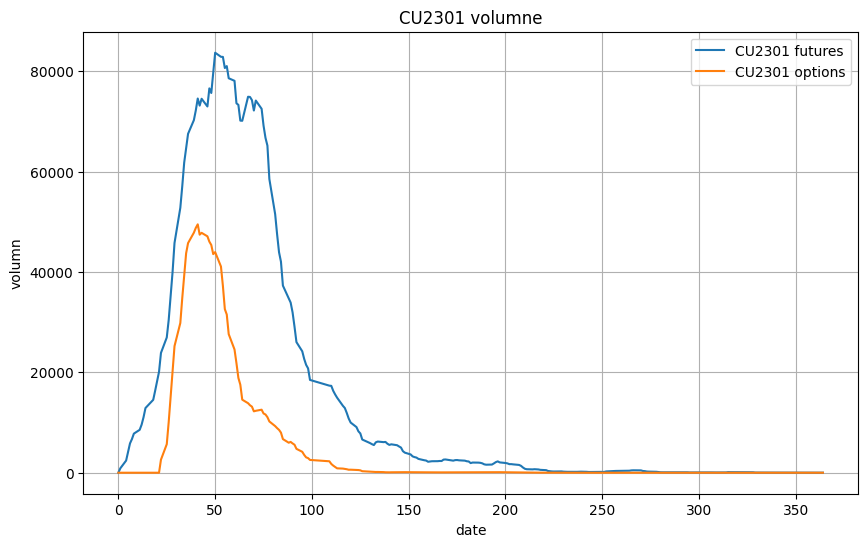

In [5]:
plt.figure(figsize=(10, 6))
smoothed = CU2301_vol.rolling(window=10,min_periods=0).mean()
plt.plot(smoothed, label=smoothed.columns)
plt.title("CU2301 volumne")
plt.xlabel('date')
plt.ylabel('volumn')

plt.legend()

plt.grid(True)

plt.show()

2、i want to get $\tau_1$ and $\tau_2$ (about a month),and the trading volume of options and futures accounts for the highest proportion of the total trading volume between $\tau_1$ and $\tau_2$

In [78]:
class total_liquid(object):
    def __init__(self,name):
        self.name = name

    def get_vol_data(self):
        _name = self.name
        options = fb.data.futuresoptions.daily(instrumentid = name)
        futures = fb.data.futures.daily(instrumentid = name)
        if options is None or futures is None:
            print('No data')
            return None
        else:
            options_vol = options['vol'].groupby(level = 'date').sum()
            options_vol.index=(futures.delist_date.iloc[0]-options_vol.index).days+1
            options_vol.name =  f'{_name} options'
            futures_vol = futures.loc[:,'vol']
            futures_vol.name =  f'{_name} futures' 
            futures_vol.index=(futures.delist_date.iloc[0]-futures_vol.index).days+1
            vol=pd.concat([futures_vol,options_vol],axis=1).sort_index()
            vol.loc[0,:]=0
            vol = vol.sort_index().fillna(0)     
            return vol
    def plot_one(self):
        _vol = self.get_vol_data()
        if _vol is None:
            pass
        else:
            plt.figure(figsize=(10, 6))
            smoothed = _vol.rolling(window=10,min_periods=0).mean()
            plt.plot(smoothed, label=smoothed.columns)
            plt.title(f"{self.name} volume")
            plt.xlabel('date')
            plt.ylabel('volume')
            plt.legend()
            plt.grid(True)
            plt.show()
    def plot_two(self):
        _vol = self.get_vol_data()
        _tau_lst,_propor = self.get_tau_two()
        if _vol is None:
            pass
        else:
            _tau1=_tau_lst[0]
            _tau2=_tau_lst[-1]
            smoothed = _vol.rolling(window=10,min_periods=0).mean()
            _min_vol = smoothed.min(axis=1)
            y = _min_vol.values
            x = np.array(_min_vol.index)

            plt.figure(figsize=(10, 6))
            plt.plot(smoothed, label=smoothed.columns)
            plt.fill_between(x, y, where=(x >= _tau1) & (x <= _tau2), color='gray', alpha=0.5)
            plt.title(f"{self.name} volume")
            plt.xlabel('date')
            plt.ylabel('volume')
            plt.legend()
            plt.grid(True)
            plt.show()   
            print(f'proportion:{_propor}')
    def get_tau_one(self):
        # in this way,i will let min(vol_option,vol_fulture) get the largest proportion between tau1 and tau2
        _vol = self.get_vol_data()
        tau_lst=None
        propor=None
        if _vol is None:
            pass
        else:
            tau2 = _vol.min(axis=1).rolling(window=30,min_periods=1).sum().idxmax()
            propor = (_vol.rolling(window=30,min_periods=1).sum().loc[tau2,:]/_vol.sum()).mean()
            tau_lst = _vol.loc[:tau2][-30:].index.tolist()
            tau1 = tau_lst[0]
        return tau_lst,propor
    def get_tau_two(self):
        # in this way,i will let min(vol_option,vol_fulture) get the largest proportion between tau1 and tau2
        _vol = self.get_vol_data()
        tau_lst=None
        propor=None
        if _vol is None:
            pass
        else:
            tau2 = (_vol.rolling(window=30,min_periods=1).sum()/_vol.sum()).sum(axis=1).idxmax()
            propor = (_vol.rolling(window=30,min_periods=1).sum().loc[tau2,:]/_vol.sum()).mean()
            tau_lst = _vol.loc[:tau2][-30:].index.tolist()
            tau1 = tau_lst[0]
        return tau_lst,propor
    def get_date(self):
        _tau_lst , _ = self.get_tau_two()
        _futures = fb.data.futures.daily(instrumentid = name)
        date_lst = []
        for i in _tau_lst:
            date_i = pd.Timedelta(days=(i-1))
            trade_date = _futures.delist_date.iloc[0] - date_i
            date_lst.append(trade_date.strftime('%Y-%m-%d'))
        return date_lst
    
    def get_propor(self):
        _vol = self.get_vol_data()
        _vol.columns = ['future_volume', 'option_volume']
        _vol['cum_propor'] = (_vol/_vol.sum())[::-1].cumsum().prod(axis=1)**0.5
        return _vol

In [75]:
# 假设你有一个 Series 或 DataFrame，名为 data
data = pd.Series([1, 2, 3, 4, 5])

# 计算正序的累积和
cumsum_forward = data.cumsum()

# 将结果反转得到倒序的累积和
cumsum_backward = cumsum_forward[::-1]

In [76]:
cumsum_forward

0     1
1     3
2     6
3    10
4    15
dtype: int64

In [77]:
cumsum_backward

4    15
3    10
2     6
1     3
0     1
dtype: int64

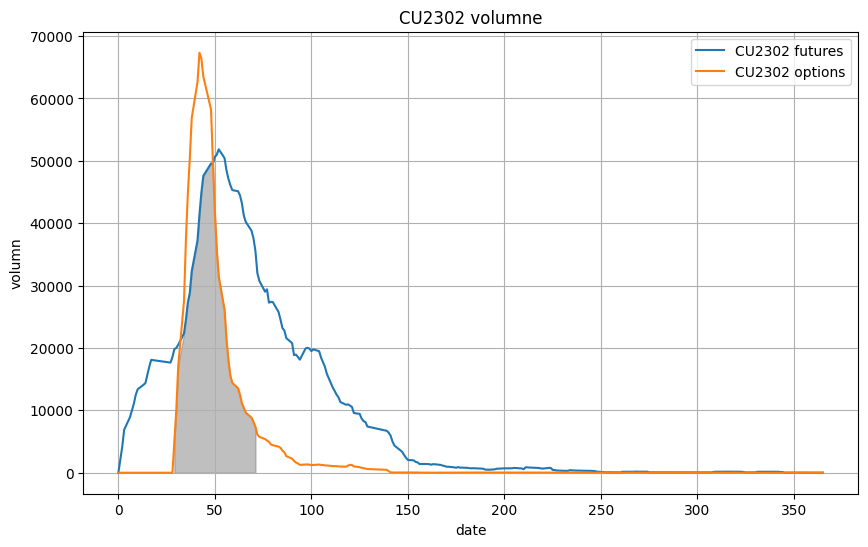

proportion:0.7486608207464367


In [7]:
name = id_lst[1]
liquid = total_liquid(name)
liquid.plot_two()

3.then, for the different options of the same fulture in one day,for put and cut options with different strike price,are traded with different price and different volume.i will compute the volatility of these options in effective dates.

In [8]:
name = id_lst[1]
liquid = total_liquid(name)
tau_lst , _ = liquid.get_tau_two()
date_lst = liquid.get_date()

In [9]:
from scipy.stats import norm
N = norm.cdf

def BS(forward, strike, mat, r, sigma, flag):
    sign = 1
    tau = mat / 360
    discount = np.exp(- r * tau)
    if flag == "P":
        sign = -1
    std_dev = sigma * np.sqrt(tau)

    d1 = np.log(forward/strike) / std_dev + 0.5 * std_dev
    d2 = d1 - std_dev
    result = discount * sign * (forward * N(sign * d1) - strike * N(sign * d2))
    return result

def IV(forward, strike, mat, r, price, flag):
    tau = mat / 360
    discount = np.exp(- r * tau)
    def root_func(x):
        return BS(forward, strike, mat, r, x, flag) - price
    sigma = newton(root_func, 0.2)
    return sigma

In [10]:
from scipy.optimize import newton
# i only calculate the volatility of in-the-money options
r=0.02
futures = fb.data.futures.daily(instrumentid = name)
all_result = []
for date in tqdm(date_lst):
    options = fb.data.futuresoptions.daily(instrumentid = name,from_date = date,to_date = date)
    options['weight']=options['vol']/options['vol'].groupby(level= 'call_put').sum()
    forward = futures.loc[date,'settle']
    future_volume = futures.loc[date,'vol']
    maturity = options.index.get_level_values('maturity')[0]
    mat=(maturity - options.index.get_level_values('date')[0]).days    
    for index in options.index:
        flag=index[2]
        strike=index[3]#strike price
        price=options.loc[index,'settle']#Option price     
        option_volume = options.loc[index,'vol']
        weight = options.loc[index,'weight'] 
        if (flag == 'C' and strike < forward) or (flag == 'P' and strike >= forward):
            try:
                volatility=IV(forward, strike, mat, r, price, flag)
                day_result = [date,maturity,flag,forward,strike,price,volatility,option_volume,future_volume,weight,mat]
                all_result.append(day_result)
            except:
                pass
volatility_one = pd.DataFrame(all_result,columns = ['trade_date','maturity','flag','forward','strike','price','volatility','option_volume','future_volume','weight','mat'])
volatility_one = volatility_one.set_index(['trade_date','maturity','mat','future_volume','forward','flag','strike'])

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]C:\Users\Administrator\AppData\Local\Temp\ipykernel_5988\3960409835.py:12: RuntimeWarning:

divide by zero encountered in scalar divide

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.69it/s]


In [11]:
volatility_one

price  \
trade_date maturity   mat future_volume forward flag strike            
2023-01-17 2023-01-18 1   23068.0       68450.0 C    64000.0  4450.0   
                                                     66000.0  2452.0   
                                                     67000.0  1490.0   
                                                     68000.0   686.0   
                                                P    69000.0   758.0   
...                                                              ...   
2022-12-07 2023-01-18 42  30537.0       65860.0 P    70000.0  4728.0   
                                                     71000.0  5554.0   
                                                     72000.0  6426.0   
                                                     73000.0  7330.0   
                                                     74000.0  8262.0   

                                                              volatility  \
trade_date maturity   mat future_volume forward flag strike                
2023-01-17 2023-01-18 1   23068.0       68450.0 C    64000.0    0.397307   
                                                     66000.0    0.279320   
                                                     67000.0    0.294065   
                                                     68000.0    0.295264   
                                                P    69000.0    0.296194   
...                                                                  ...   
2022-12-07 2023-01-18 42  30537.0       65860.0 P    70000.0    0.219713   
                                                     71000.0    0.219840   
                                                     72000.0    0.220543   
                                                     73000.0    0.220829   
                                                     74000.0    0.221589   

                                                              option_volume  \
trade_date maturity   mat future_volume forward flag strike                   
2023-01-17 2023-01-18 1   23068.0       68450.0 C    64000.0           47.0   
                                                     66000.0          253.0   
                                                     67000.0          237.0   
                                                     68000.0         1471.0   
                                                P    69000.0         1168.0   
...                                                                     ...   
2022-12-07 2023-01-18 42  30537.0       65860.0 P    70000.0           11.0   
                                                     71000.0            5.0   
                                                     72000.0            2.0   
                                                     73000.0           13.0   
                                                     74000.0            0.0   

                                                                weight  
trade_date maturity   mat future_volume forward flag strike             
2023-01-17 2023-01-18 1   23068.0       68450.0 C    64000.0  0.001936  
                                                     66000.0  0.010419  
                                                     67000.0  0.009760  
                                                     68000.0  0.060577  
                                                P    69000.0  0.044294  
...                                                                ...  
2022-12-07 2023-01-18 42  30537.0       65860.0 P    70000.0  0.003003  
                                                     71000.0  0.001365  
                                                     72000.0  0.000546  
                                                     73000.0  0.003549  
                                                     74000.0  0.000000  

[697 rows x 4 columns]

4、then i will calibrate the volatility through sabr model.In this step, I would give greater weight to options with greater trading volume

In [12]:
class sabr(object):
    def __init__(self, alpha, beta, rho, volvol):
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.volvol = volvol
        
    def lognormal_vol(self, k, f, t):
        alpha, beta, rho, volvol = self.alpha ,self.beta ,self.rho ,self.volvol
        # Negative strikes or forwards
        if k <= 0 or f <= 0:
            return 0.
        eps = 1e-07
        logfk = np.log(f / k)
        fkbeta = (f*k)**(1 - beta)
        a = (1 - beta)**2 * alpha**2 / (24 * fkbeta)
        b = 0.25 * rho * beta * volvol * alpha / fkbeta**0.5
        c = (2 - 3*rho**2) * volvol**2 / 24
        d = fkbeta**0.5
        v = (1 - beta)**2 * logfk**2 / 24
        w = (1 - beta)**4 * logfk**4 / 1920
        z = volvol * fkbeta**0.5 * logfk / alpha
        if abs(z) > eps:
            vz = alpha * z * (1 + (a + b + c) * t) / (d * (1 + v + w) * self._x(z))
            return vz
        # ATM
        else:
            v0 = alpha * (1 + (a + b + c) * t) / (d * (1 + v + w))
            return v0

    def _x(self, z):
        rho = self.rho
        a = (1 - 2*rho*z + z**2)**.5 + z - rho
        b = 1 - rho
        return np.log(a / b)

In [13]:
initial_guess = [0.01, 0.00, 0.10, 0.5]
x0 = np.array(initial_guess)
bounds = [(0.0001, None), (-0.9999, 0.9999), (0.0001, None), (0.0001, None)]

In [14]:
from scipy.optimize import minimize
dates = np.unique(volatility_one.index.get_level_values('trade_date'))
result_all = []
for date in tqdm(dates):
    volatility_day = volatility_one.loc[(volatility_one.index.get_level_values('trade_date') == date), :]
    strikes = volatility_day.index.get_level_values('strike')
    forward = volatility_day.index.get_level_values('forward')[0]
    mat = volatility_day.index.get_level_values('mat')[0]
    weight = volatility_day.loc[:,'weight'].values
    vols_BS = volatility_day.loc[:,'volatility'].values
    
    def vol_square_error(x):
        sabr0 = sabr(x[0], x[1], x[2], x[3])
        vols = np.array([sabr0.lognormal_vol(k_, forward, mat / 360)*100 for k_ in strikes])
        return sum(((vols - vols_BS)*weight)**2)
    
    res = minimize(vol_square_error, x0, method='L-BFGS-B', bounds=bounds)
    alpha, beta, rho, volvol = res.x
    success = res.success
    resid = res.fun
    result_date = [alpha, beta, rho, volvol,success,resid]
    result_all.append(result_date)
sabr_para = pd.DataFrame(result_all,columns = ['alpha', 'beta', 'rho', 'volvol','success','resid'],index = dates)

  0%|                                                                                           | 0/29 [00:00<?, ?it/s]C:\Users\Administrator\AppData\Local\Temp\ipykernel_5988\3538839679.py:35: RuntimeWarning:

invalid value encountered in log

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5988\3538839679.py:33: RuntimeWarning:

invalid value encountered in scalar power

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 42.29it/s]


In [15]:
sabr_para

,alpha,beta,rho,volvol,success,resid
2022-12-07,0.010000,1.491841e-05,0.100392,0.500001,True,6.496361e-05
2022-12-08,0.010000,4.025781e-09,0.100000,0.500000,True,1.864442e-04
2022-12-09,0.009761,-3.436549e-05,0.099758,0.499905,True,1.164008e-04
2022-12-12,0.205895,5.956177e-01,0.202958,0.006612,True,9.575167e-10
2022-12-13,0.152455,6.217102e-01,0.705958,0.001136,True,7.897935e-10
2022-12-14,0.192591,5.987134e-01,0.144284,0.005228,True,3.761229e-10
2022-12-15,0.448992,5.169983e-01,0.489325,0.000100,True,9.246544e-10
2022-12-16,0.010000,-1.366157e-14,0.100000,0.500000,True,5.519105e-05
2022-12-19,0.141650,6.208862e-01,0.154526,0.019693,True,1.622580e-08
2022-12-20,1.046928,4.403835e-01,0.245204,0.008660,True,3.896881e-09


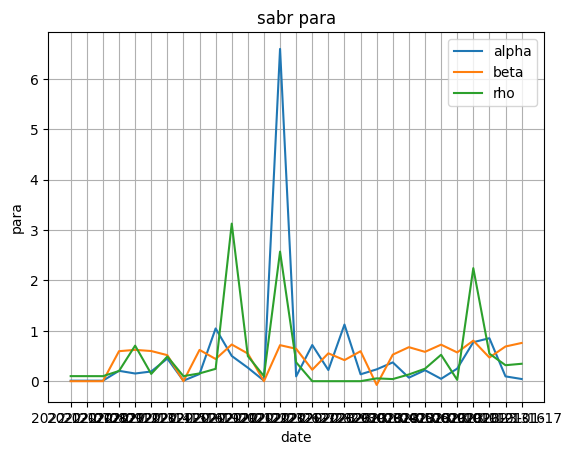

In [16]:
plt.xlabel('date') 
plt.ylabel('para') 
plt.title("sabr para")
plt.plot(sabr_para.iloc[:,:3], label=sabr_para.iloc[:,:3].columns)
plt.grid(True)  
plt.legend()
plt.show()

5.then i will take all options of copper futures into account;first i want to know the proper trade date

the first idea:for the real data,i know the volume of option and future before; i want to choose one day to start compute volatility; the volume have differen size;so only consider the volumn is meaningless；it is easy to see,the volume's proportion relate to date;then i want to extract a little useful information from the trading volume of futures and options（maybe $\frac{volumn_{futures}}{volumn_{options}}$ ）

In [17]:
id_lst = [ f'CU230{i+1}' for i in range(12)] + [ f'CU240{i+1}' for i in range(2)]
tau_all = []
proportion_all = []
names = []
for name in tqdm(id_lst):
    liquid = total_liquid(name)
    tau_lst , proportion = liquid.get_tau_two()
    if tau_lst is None:
        pass
    else:
        tau_all.append(tau_lst)
        proportion_all.append(proportion)
        names.append(name)
index = pd.MultiIndex.from_arrays([proportion_all,names], names=('proportion', 'underlyingid'))
tau_all_df = pd.DataFrame(tau_all,index = index)

 64%|█████████████████████████████████████████████████████▎                             | 9/14 [00:05<00:02,  1.78it/s]

Query return empty dataframe.

Query return empty dataframe.

 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [00:05<00:01,  2.11it/s]

No data


Query return empty dataframe.

Query return empty dataframe.

 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [00:05<00:01,  2.44it/s]

No data


Query return empty dataframe.

Query return empty dataframe.

 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [00:06<00:00,  2.72it/s]

No data


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.01it/s]


In [18]:
tau_all_df

,,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
proportion,underlyingid,,,,,,,,,,,,,,,,,,,,,
0.723747,CU2301,26,27,28,29,32,33,34,35,36,39,...,54,55,56,57,60,61,62,63,64,67
0.748661,CU2302,29,30,31,34,35,36,37,38,41,42,...,58,59,62,63,64,65,66,69,70,71
0.792006,CU2303,23,24,27,28,29,30,31,34,35,36,...,58,59,62,63,64,65,66,69,70,71
0.803615,CU2304,22,25,26,27,28,29,32,33,34,35,...,50,53,54,55,56,57,60,61,62,63
0.776226,CU2305,22,25,26,27,28,29,32,33,34,35,...,53,54,55,56,57,60,61,62,63,64
0.818691,CU2306,22,23,24,25,28,29,30,31,32,35,...,53,56,57,58,59,60,63,64,65,66
0.821452,CU2307,22,27,28,29,32,33,34,35,36,39,...,54,55,56,57,60,61,62,63,64,67
0.727342,CU2308,22,23,26,27,28,29,30,33,34,35,...,50,51,56,57,58,61,62,63,64,65
0.756603,CU2309,23,24,25,26,29,30,31,32,33,36,...,51,52,53,54,57,58,59,60,61,64


so far:it seems at least for the copper;the date is enough to choose the start date ,then i will see the all future 

In [19]:
all_options = fb.data.futuresoptions.info()

In [43]:
underlyingid0 = np.unique(all_options.index.get_level_values('underlyingid'))
underlyingid_lst = [s for s in underlyingid0 if int(s[-4:-2]) == 23 or (int(s[-4:-2]) == 24 and int(s[-2:]) <= 3)]

In [44]:
# it is too slow,so i will run parallel

# def get_all_tau(name):
#     liquid = total_liquid(name)
#     tau_lst , proportion = liquid.get_tau_two()   
#     if tau_lst is None:
#         pass
#     else:
#         return tau_lst,proportion,name
# with Pool(6) as p:
#     res_lst = list(tqdm(p.imap(get_all_tau,underlyingid_lst),total = len(underlyingid_lst)))

In [45]:
tau_all = []
proportion_all = []
names = []
names_id = []
for name in tqdm(underlyingid_lst):
    liquid = total_liquid(name)
    tau_lst , proportion = liquid.get_tau_two()
    if tau_lst is None:
        pass
    else:
        tau_all.append(tau_lst)
        proportion_all.append(proportion)
        names.append(name)
        names_id.append(name[:-4])
index = pd.MultiIndex.from_arrays([names_id,proportion_all,names], names=('id', 'proportion','underlyingid'))
tau_all_df = pd.DataFrame(tau_all,index = index)

 72%|█████████████████████████████████████████████████████████▋                      | 279/387 [03:05<01:02,  1.74it/s]

Query return empty dataframe.

 72%|█████████████████████████████████████████████████████████▉                      | 280/387 [03:05<00:54,  1.95it/s]

No data


Query return empty dataframe.

 73%|██████████████████████████████████████████████████████████                      | 281/387 [03:06<00:48,  2.17it/s]

No data


Query return empty dataframe.

 73%|██████████████████████████████████████████████████████████▎                     | 282/387 [03:06<00:44,  2.36it/s]

No data


Query return empty dataframe.

 73%|██████████████████████████████████████████████████████████▌                     | 283/387 [03:06<00:42,  2.46it/s]

No data


 74%|██████████████████████████████████████████████████████████▉                     | 285/387 [03:07<00:46,  2.22it/s]

Query return empty dataframe.

 74%|███████████████████████████████████████████████████████████                     | 286/387 [03:08<00:43,  2.33it/s]

No data


 74%|███████████████████████████████████████████████████████████▌                    | 288/387 [03:09<00:42,  2.31it/s]

Query return empty dataframe.

 75%|███████████████████████████████████████████████████████████▋                    | 289/387 [03:09<00:41,  2.37it/s]

No data


 75%|████████████████████████████████████████████████████████████▏                   | 291/387 [03:10<00:43,  2.22it/s]

Query return empty dataframe.

 75%|████████████████████████████████████████████████████████████▎                   | 292/387 [03:10<00:40,  2.32it/s]

No data


100%|████████████████████████████████████████████████████████████████████████████████| 387/387 [04:09<00:00,  1.55it/s]


In [47]:
tau_all_df.loc[tau_all_df.index.get_level_values('id') == 'A']

0     1     2     3     4     5     6     7   \
id proportion underlyingid                                                 
A  0.685934   A2301         48  49.0  50.0  53.0  54.0  55.0  56.0  57.0   
   0.633425   A2303         55  56.0  57.0  58.0  61.0  62.0  63.0  64.0   
   0.472031   A2305         44  45.0  48.0  49.0  50.0  51.0  52.0  55.0   
   0.746881   A2307         40  43.0  44.0  45.0  46.0  47.0  50.0  51.0   
   0.658108   A2309         50  51.0  52.0  53.0  56.0  57.0  58.0  59.0   
   0.603607   A2311         49  50.0  51.0  54.0  55.0  56.0  57.0  58.0   
   0.648678   A2401         43  46.0  47.0  48.0  49.0  50.0  53.0  54.0   
   0.599524   A2403         44  45.0  46.0  49.0  50.0  51.0  52.0  53.0   

                              8     9   ...    20    21    22    23    24  \
id proportion underlyingid              ...                                 
A  0.685934   A2301         60.0  61.0  ...  76.0  77.0  78.0  81.0  82.0   
   0.633425   A2303         65.0  68.0  ...  84.0  85.0  86.0  89.0  90.0   
   0.472031   A2305         56.0  57.0  ...  72.0  73.0  76.0  77.0  78.0   
   0.746881   A2307         52.0  53.0  ...  68.0  71.0  72.0  78.0  79.0   
   0.658108   A2309         60.0  63.0  ...  78.0  79.0  80.0  81.0  86.0   
   0.603607   A2311         61.0  62.0  ...  77.0  78.0  79.0  82.0  83.0   
   0.648678   A2401         55.0  56.0  ...  71.0  74.0  75.0  76.0  77.0   
   0.599524   A2403         56.0  57.0  ...  72.0  73.0  77.0  78.0  79.0   

                              25    26    27    28    29  
id proportion underlyingid                                
A  0.685934   A2301         83.0  84.0  85.0  88.0  89.0  
   0.633425   A2303         91.0  92.0  93.0  96.0  97.0  
   0.472031   A2305         79.0  80.0  83.0  84.0  85.0  
   0.746881   A2307         80.0  81.0  82.0  85.0  86.0  
   0.658108   A2309         87.0  88.0  91.0  92.0  93.0  
   0.603607   A2311         84.0  85.0  86.0  89.0  90.0  
   0.648678   A2401         78.0  81.0  82.0  83.0  84.0  
   0.599524   A2403         80.0  81.0  84.0  85.0  86.0  

[8 rows x 30 columns]

as we can see for different underlying, the proper date is different;then i will create a method to choose the start date and the end date

my requirements：           
1、[start_date,end_date] contains at least 70% of trading volume (The geometric mean of the proportion of options trading volume and the proportion of futures trading volume)           
2、(end_date - start_date) is as smaller as better      
3、(end_date - start_date) is bigger than 30 to get enough sample points     

In [267]:
# first,get the data set
names = tau_all_df.loc[tau_all_df.index.get_level_values('id') == 'CU'].index.get_level_values('underlyingid')
proportion_lst = []
fit_lst = []
for name in tqdm(names):
    liquid = total_liquid(name)
    proportion = liquid.get_propor()
    # I will remove some useless information based on option_volume
    zeros_mask = (proportion['option_volume'].shift(1)+proportion['option_volume'].shift(-1)).fillna(0) != 0
    proportion_fit = proportion[zeros_mask]
    if tau_lst is None:
        pass
    else:
        proportion_fit['total_volume'] = proportion_fit['option_volume']/proportion_fit['future_volume']
        proportion_fit['option_volume_change'] = proportion_fit['option_volume']/proportion_fit['option_volume'].shift(-1) -1
        proportion_fit['future_volume_change'] = proportion_fit['future_volume']/proportion_fit['future_volume'].shift(-1) -1
        proportion_fit['total_volume_cumsum'] = proportion_fit['total_volume'][::-1].cumsum()
        proportion_fit['total_volume_cumsum_op'] = proportion_fit['total_volume_cumsum']-proportion_fit['total_volume_cumsum'][::-1].expanding().mean()

        # moreover ,When cum_propor is close to 0 or 1, it is difficult to fit. In fact, we do not need this part of the data.
        fit_mask = (proportion_fit['cum_propor']>0.03)
        fit_lst.append(fit_mask)
        proportion_lst.append(proportion_fit)

    
proportion_df = pd.concat(proportion_lst,axis =0)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.71it/s]


In [268]:
proportion_df

,future_volume,option_volume,cum_propor,total_volume,option_volume_change,future_volume_change,total_volume_cumsum,total_volume_cumsum_op
date,,,,,,,,
21,31142.0,0.0,0.972792,0.000000,-1.000000,-0.359719,22.277709,16.940557
22,48638.0,26030.0,0.968467,0.535178,-0.155747,0.078878,22.277709,17.070868
25,45082.0,30832.0,0.951474,0.683909,-0.303121,-0.078040,21.742531,16.668023
26,48898.0,44243.0,0.933058,0.904802,-0.137042,-0.257039,21.058622,16.114332
27,65815.0,51269.0,0.908716,0.778987,0.051003,-0.084249,20.153820,15.336415
...,...,...,...,...,...,...,...,...
180,185.0,288.0,0.002962,1.556757,1.742857,-0.046392,4.664024,2.265878
183,194.0,105.0,0.002410,0.541237,-0.441489,-0.058252,3.107268,1.275591
184,206.0,188.0,0.002170,0.912621,-0.353952,0.170455,2.566030,1.159551


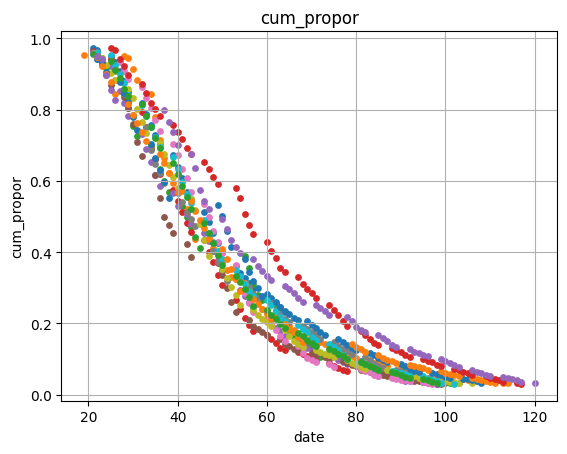

In [269]:
plt.xlabel('date') 
plt.ylabel('cum_propor') 
plt.title("cum_propor")
for i in range(len(proportion_lst)):
    plt.scatter(proportion_lst[i][fit_lst[i]].index,proportion_lst[i][fit_lst[i]].cum_propor,s= 15)
plt.grid(True)  
plt.show()

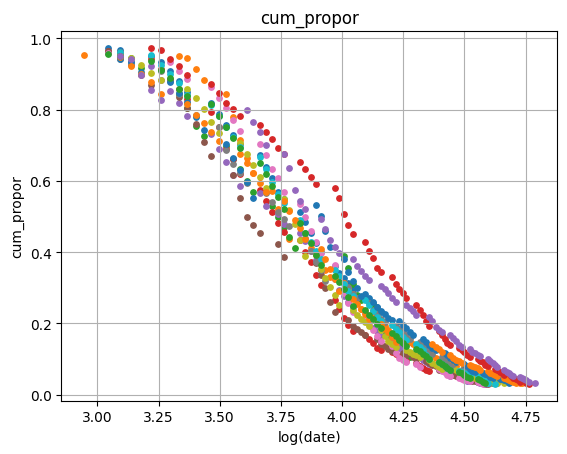

In [270]:
plt.xlabel('log(date)') 
plt.ylabel('cum_propor') 
plt.title("cum_propor")
for i in range(len(proportion_lst)):
    plt.scatter(np.log(proportion_lst[i][fit_lst[i]].index),proportion_lst[i][fit_lst[i]].cum_propor,s= 15)
plt.grid(True)  
plt.show()

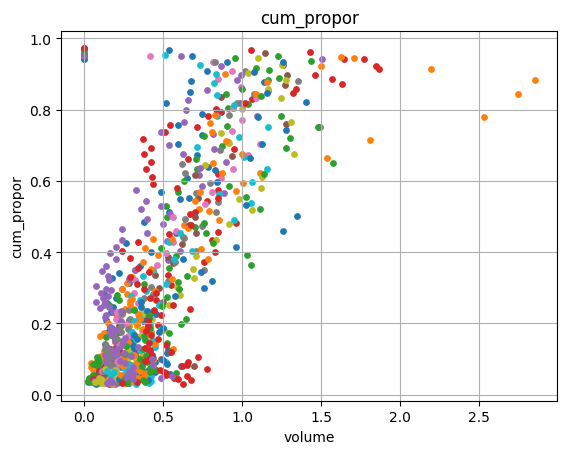

In [271]:
plt.xlabel('volume') 
plt.ylabel('cum_propor') 
plt.title("cum_propor")
for i in range(len(proportion_lst)):
    plt.scatter(proportion_lst[i][fit_lst[i]].total_volume,proportion_lst[i][fit_lst[i]].cum_propor,s= 15)
plt.grid(True)  
plt.show()

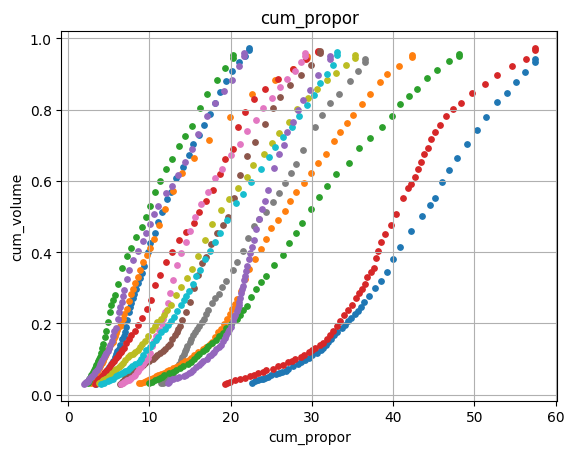

In [272]:
plt.ylabel('cum_volume') 
plt.xlabel('cum_propor') 
plt.title("cum_propor")
for i in range(len(proportion_lst)):
    plt.scatter(proportion_lst[i][fit_lst[i]].total_volume_cumsum,proportion_lst[i][fit_lst[i]].cum_propor,s= 15)
plt.grid(True)  
plt.show()

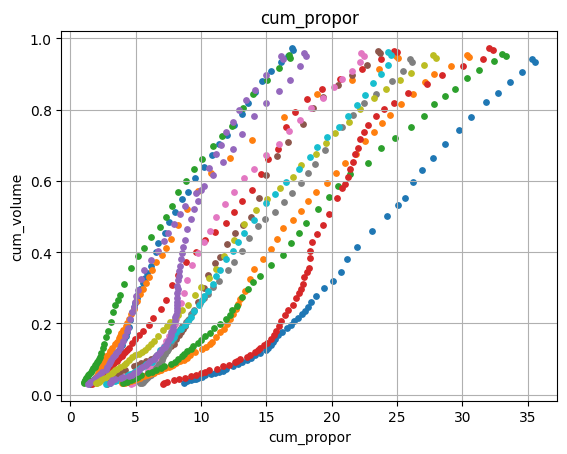

In [273]:
plt.ylabel('cum_volume') 
plt.xlabel('cum_propor') 
plt.title("cum_propor")
for i in range(len(proportion_lst)):
    plt.scatter(proportion_lst[i][fit_lst[i]].total_volume_cumsum_op,proportion_lst[i][fit_lst[i]].cum_propor,s= 15) 
plt.grid(True)  
plt.show()

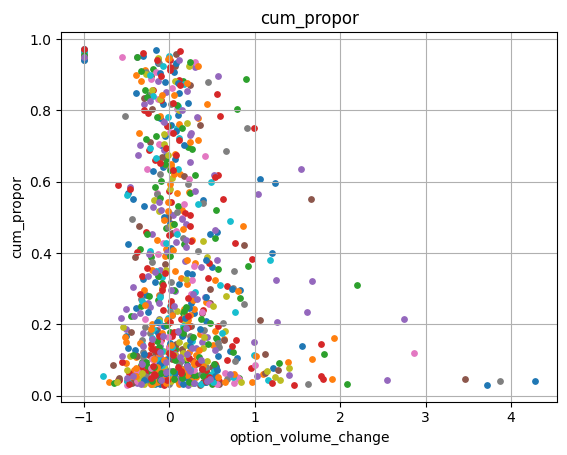

In [274]:
plt.xlabel('option_volume_change') 
plt.ylabel('cum_propor') 
plt.title("cum_propor")
for i in range(len(proportion_lst)):
    plt.scatter(proportion_lst[i][fit_lst[i]].option_volume_change,proportion_lst[i][fit_lst[i]].cum_propor,s= 15)
plt.grid(True)  
plt.show()

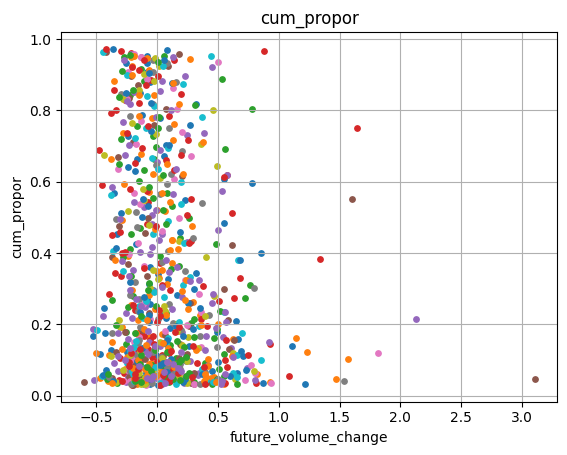

In [275]:
plt.xlabel('future_volume_change') 
plt.ylabel('cum_propor') 
plt.title("cum_propor")
for i in range(len(proportion_lst)):
    plt.scatter(proportion_lst[i][fit_lst[i]].future_volume_change,proportion_lst[i][fit_lst[i]].cum_propor,s= 15)
plt.grid(True)  
plt.show()

i find two effective factors:log(date)、cumsum(option_volume/future_volume)           
it is easy to find the linear relationship
                                        

In [276]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

class helper_fit(object):
    def __init__(self,data1,data2 = None):
        if data2 is None:
            x = np.array(data1.index)
            y = np.array(data1)
        else:
            if isinstance(data1, np.ndarray):
                x = data1
            else:
                x = np.array(data1)
            if isinstance(data2, np.ndarray):
                y = data2
            else:
                y = np.array(data2)
            if x.ndim == 1:
                x = x[:, np.newaxis]
            # dropna
            x_drna = ~np.isnan(x).any(axis=1) & np.isfinite(x).all(axis=1)
            y_drna = ~np.isnan(y) & np.isfinite(y)
            drnan_indices = x_drna*y_drna
            self.x = x[drnan_indices]
            self.y = y[drnan_indices]
    def data_partition(self):
        kf = KFold(n_splits=10)
        for train_index, test_index in kf.split(self.x):
            x_train, x_test = self.x[train_index], self.x[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]
            break
        return x_train, x_test, y_train, y_test
    def evaluate(self):
        mse = []
        R_2 = []
        for i in range(100):
            x_train, x_test, y_train, y_test = self.data_partition()
            model = LinearRegression()
            hypothesis = model.fit(x_train, y_train)
            hpyTrain = model.predict(x_train)
            hpyTest = model.predict(x_test)  
            ssResTest = sum((hpyTest - y_test)**2)                   
            ssTotTest = sum((y_test - np.mean(y_test))**2)            
            Rsquare = 1 - ssResTest / ssTotTest  
            mse.append(ssResTest)
            R_2.append(Rsquare)
        print(f'mse of test set：{np.mean(mse)}')
        print(f'Rsquare of test set：{np.mean(R_2)}')

In [291]:
print('only take date into account')
eva = helper_fit(proportion_df['log_date'],proportion_df['cum_propor'])
eva.evaluate()

print('\ntake date and date**2 into account')
eva = helper_fit(pd.concat([proportion_df['log_date'],proportion_df['log_date']**2],axis = 1),proportion_df['cum_propor'])
eva.evaluate()

proportion_df['log_date'] = np.log(proportion_df.index)
print('\ntake both date and cum_volume into account')
eva = helper_fit(proportion_df[['total_volume_cumsum','log_date']],proportion_df['cum_propor'])
eva.evaluate()

print('\ntake both date and cum_volume_op into account')
eva = helper_fit(proportion_df[['total_volume_cumsum_op','log_date']],proportion_df['cum_propor'])
eva.evaluate()

print('\ntake date, date**2 and cum_volume_op into account')
eva = helper_fit(pd.concat([proportion_df['log_date'],proportion_df['log_date']**2,proportion_df['total_volume_cumsum_op']],axis = 1),proportion_df['cum_propor'])
eva.evaluate()

print('\nonly take cum_volume_op into account')
eva = helper_fit(proportion_df['total_volume_cumsum_op'],proportion_df['cum_propor'])
eva.evaluate()

print('\ntake cum_volume_op and cum_volume_op**2 into account')
eva = helper_fit(pd.concat([proportion_df['total_volume_cumsum_op'],proportion_df['total_volume_cumsum_op']**2],axis = 1),proportion_df['cum_propor'])
eva.evaluate()

only take date into account
mse of test set：2.8542209038467052
Rsquare of test set：0.8003067791807136

take date and date**2 into account
mse of test set：0.3736025378052477
Rsquare of test set：0.9738612053537831

take both date and cum_volume into account
mse of test set：2.6082567580656826
Rsquare of test set：0.8175154585828159

take both date and cum_volume_op into account
mse of test set：2.224973152436164
Rsquare of test set：0.8443315811864426

take date, date**2 and cum_volume_op into account
mse of test set：0.45490010623871
Rsquare of test set：0.9681732877636012

only take cum_volume_op into account
mse of test set：5.180796390180783
Rsquare of test set：0.6375298365414469

take cum_volume_op and cum_volume_op**2 into account
mse of test set：5.59524576816803
Rsquare of test set：0.6085332262772304


as we can see;take date and date**2 into account is best

In [313]:
def get_proper_day(data):
    eva = helper_fit(pd.concat([data['log_date'],data['log_date']**2],axis = 1),data['cum_propor'])
    x = eva.x
    y = eva.y
    model = LinearRegression()
    hypothesis = model.fit(x, y)
    hpy = model.predict(x)
    hpy_df = pd.DataFrame({'date':data['log_date'].apply(np.exp),'predict':hpy})
    hpy_df['date'] = hpy_df['date'].astype(int) 
    hpy_df.set_index('date', inplace=True)
    a = hpy_df.shift(30) - hpy_df
    return a

In [300]:
get_proper_day(proportion_df)

,predict
date,
21,1.132621
22,1.082052
24,0.948981
26,0.909884
27,0.873029
...,...
180,-0.009951
183,-0.009289
184,-0.009039


,predict
date,
21,NaN
22,NaN
24,NaN
26,NaN
27,NaN
...,...
180,NaN
183,NaN
184,NaN
